<a href="https://colab.research.google.com/github/soucs/ac-gans/blob/main/ac_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, FashionMNIST
from torch.nn.functional import one_hot

# mnist = MNIST(root='data', 
#               train=True, 
#               download=True,
#               transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
fmnist = FashionMNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

fmnist_test = FashionMNIST(root='data', 
              train=False, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
image_size = 784
n_classes = 10

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# View image
def view(img):
  img = img.reshape(28,28)
  img_norm = denorm(img).detach()
  plt.imshow(img_norm, cmap='gray')
def get_z(classes):
  z = torch.randn(batch_size, latent_size)
  y = one_hot(classes.reshape(batch_size),num_classes = n_classes)
  z = torch.cat([z, y], dim=1)
  return z

In [5]:
batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)
test_dl = DataLoader(fmnist_test, batch_size=1, shuffle=True)

In [6]:
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2))
D_out = nn.Sequential(
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
A_out = nn.Sequential(
    nn.Linear(hidden_size, 10),
    nn.Softmax())

In [7]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size+n_classes, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [8]:
# def train_discriminator(images,classes):
#     real_labels = torch.ones(batch_size)
#     fake_labels = torch.zeros(batch_size)
        
#     # Loss for real images
#     outputs = D(images)
#     out, out_class = outputs[:,0], outputs[:,1:]
#     d_loss_real = criterion(out, real_labels)
#     d_loss_rclass = aux_criterion(out_class, classes)

#     # Loss for fake images
#     z = embedder(classes)
#     fake_images = G(z)
#     outputs = D(fake_images)
#     out, out_class = outputs[:,0], outputs[:,1:]
#     d_loss_fake = criterion(out, fake_labels)
#     d_loss_fclass = aux_criterion(out_class, classes)

#     # Combine losses
#     Ls = d_loss_real + d_loss_fake
#     Lc = d_loss_rclass + d_loss_fclass
#     d_loss = Lc + Ls

#     reset_grad()
#     d_loss.backward()
#     d_optimizer.step()
    
#     return d_loss, Ls, Lc

In [9]:
criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()

# Train Discriminator
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def train_discriminator(images,classes):
    real_labels = torch.ones(batch_size,1)
    fake_labels = torch.zeros(batch_size,1)
        
    # Loss for real images
    outputs = D(images)
    rf_out = D_out(outputs)
    aux_out = A_out(outputs)
    d_loss_real = criterion(rf_out, real_labels)
    d_loss_rclass = aux_criterion(aux_out, classes)

    # Loss for fake images
    z = get_z(classes)
    fake_images = G(z)
    outputs = D(fake_images)
    rf_out = D_out(outputs)
    aux_out = A_out(outputs)
    d_loss_fake = criterion(rf_out, fake_labels)
    d_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    Ls = d_loss_real + d_loss_fake
    Lc = d_loss_rclass + d_loss_fclass
    d_loss = Lc + Ls

    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss

# Train Generator
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator(classes):
    # Generate fake images and calculate loss
    real_labels = torch.ones(batch_size,1)

    # Loss for fake images
    z = get_z(classes)
    fake_images = G(z)
    outputs = D(fake_images)
    rf_out = D_out(outputs)
    aux_out = A_out(outputs)
    g_loss_fake = criterion(rf_out, real_labels)
    g_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    # Ls = g_loss_real + g_loss_fake
    # Lc = g_loss_rclass + g_loss_fclass
    # g_loss = Ls - Lc
    g_loss = g_loss_fake + g_loss_fclass

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss

def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [10]:
# for images,classes in data_loader:
#   images = images.reshape(batch_size, -1)
#   ld = train_discriminator(images,classes)
#   lg = train_generator(classes)
#   print(ld,lg)
#   break

Saving fake_images-0000.png


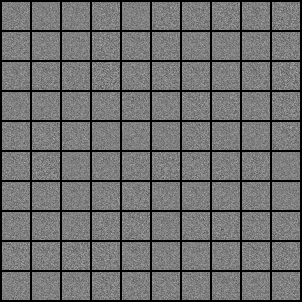

In [11]:
import os
from IPython.display import Image
from torchvision.utils import save_image

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

for i, classes in data_loader:
    sample_vectors = get_z(classes)
    break

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    for i, (images, classes) in enumerate(data_loader):
        images = images.reshape(batch_size, -1)
        d_loss = train_discriminator(images,classes)
        g_loss = train_generator(classes)

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
          .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))
    
    
    # Sample and save images
    save_fake_images(epoch+1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/100], Step [600/600], d_loss: 4.2145, g_loss: 5.1376
Saving fake_images-0001.png
Epoch [2/100], Step [600/600], d_loss: 4.1814, g_loss: 6.0891
Saving fake_images-0002.png
Epoch [3/100], Step [600/600], d_loss: 4.0261, g_loss: 7.2468
Saving fake_images-0003.png
Epoch [4/100], Step [600/600], d_loss: 4.1519, g_loss: 6.8055
Saving fake_images-0004.png
Epoch [5/100], Step [600/600], d_loss: 4.2626, g_loss: 6.5033
Saving fake_images-0005.png
Epoch [6/100], Step [600/600], d_loss: 4.0086, g_loss: 7.9218
Saving fake_images-0006.png
Epoch [7/100], Step [600/600], d_loss: 4.1017, g_loss: 7.0007
Saving fake_images-0007.png
Epoch [8/100], Step [600/600], d_loss: 4.1231, g_loss: 5.8017
Saving fake_images-0008.png
Epoch [9/100], Step [600/600], d_loss: 4.2735, g_loss: 6.1630
Saving fake_images-0009.png
Epoch [10/100], Step [600/600], d_loss: 4.1307, g_loss: 6.8958
Saving fake_images-0010.png
Epoch [11/100], Step [600/600], d_loss: 4.1421, g_loss: 6.9996
Saving fake_images-0011.png
Epoch [1

In [ ]:
import cv2
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

# Testing

In [ ]:
fmnist_test = FashionMNIST(root='data', 
              train=False, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
test_dl = DataLoader(fmnist_test, batch_size, shuffle=True)

def ssim(imgx,imgy):
  K1, K2, L = 0.01, 0.03, 255
  C1, C2 = (K1*L)**2, (K2*L)**2
  C3 = C2/2

  mu_x = torch.mean(imgx)
  mu_y = torch.mean(imgy)
  sd_x = torch.std(imgx)
  sd_y = torch.std(imgy)
  concat = torch.cat([imgx.flatten(),imgy.flatten()])
  cov_xy = torch.cov(concat) #[0,1]

  l = (2*mu_x*mu_y + C1)/(mu_x**2 + mu_y**2 + C1)
  c = (2*sd_x*sd_y + C2)/(sd_x**2 + sd_y**2 + C2)
  s = (cov_xy + C3)/(sd_x*sd_y + C3)

  return l*c*s

In [ ]:
for i, (images, classes) in enumerate(test_dl):
    images = images.reshape(batch_size, -1)
    z = get_z(classes)
    fake_images = G(z)
    sim_scores = []
    for i in range(10):
        class_imgs = fake_images[np.where(classes==i)]
        try:
          imgx = class_imgs[0]
          imgy = class_imgs[1]
          sim_scores.append(ssim(imgx,imgy))
        except IndexError:
          continue
    sim_loss = torch.mean(torch.tensor(sim_scores))
    print(sim_loss)

In [ ]:
# from torch.nn.functional import one_hot
# import torch
# for d in data_loader:
#   inp = d[1].detach().clone()
#   break
# print(one_hot(inp,num_classes=10))